# **Question Answering on Standford's SQuAD2.0**

When it comes to Natural Language Processing, understading and responding to questions asked in everyday language is a critical task. The goal of this notebook is to showcase the potential of the [**Standford SQuaD2.0 dataset**](https://rajpurkar.github.io/SQuAD-explorer/), specifically made for **Question Answering**, by using it to train 3 very capable Transformer-based models like Google's **BERT**, Facebook AI's **RoBERTa** and Hugging Face's **DistilBERT**.

**SQuAD** consists of a set of around 150,000 questions collected by crowdworkers on a specific set of Wikipedia articles, so that the answer to every question is either a span of **text** from the article, or the question might be **unanswerable**. The goal of a model trained on this dataset is to be able to not only **answer** the questions when possible, but also **refrain** from answering when a question is unanswerable.

## **Exploratory Data Analysis**

We start by **importing** the dataset.

In [1]:
!pip install transformers

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from subprocess import check_output
from transformers.data.processors.squad import SquadV2Processor
import seaborn as sns
sns.set_palette("viridis")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def json_to_dataframe():
  processor = SquadV2Processor()
  examples = processor.get_train_examples('/kaggle/input/squad-2/')
  qas_id = [example.qas_id for example in examples]
  question_text = [example.question_text for example in examples]
  context_text = [example.context_text for example in examples]
  answer_text = [example.answer_text for example in examples]
  start_position = [example.start_position for example in examples]
  end_position = [example.end_position for example in examples]
  is_impossible = [example.is_impossible for example in examples]

  # create the DataFrame
  df = pd.DataFrame({
      'qas_id': qas_id,
      'question_text': question_text,
      'context_text': context_text,
      'answer_text': answer_text,
      'start_position': start_position,
      'end_position': end_position,
      'is_impossible': is_impossible,
  })
  return df

Just to see what we're working with, we print the **first five instances**.

In [3]:
df = json_to_dataframe()

df.head(5)

100%|██████████| 442/442 [01:21<00:00,  5.44it/s]


,qas_id,question_text,context_text,answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,41,42,False


## **Plots**

Now we draw a few significant **plots** to better understand the dataset.

First, we plot the **length** of the text we're working with.

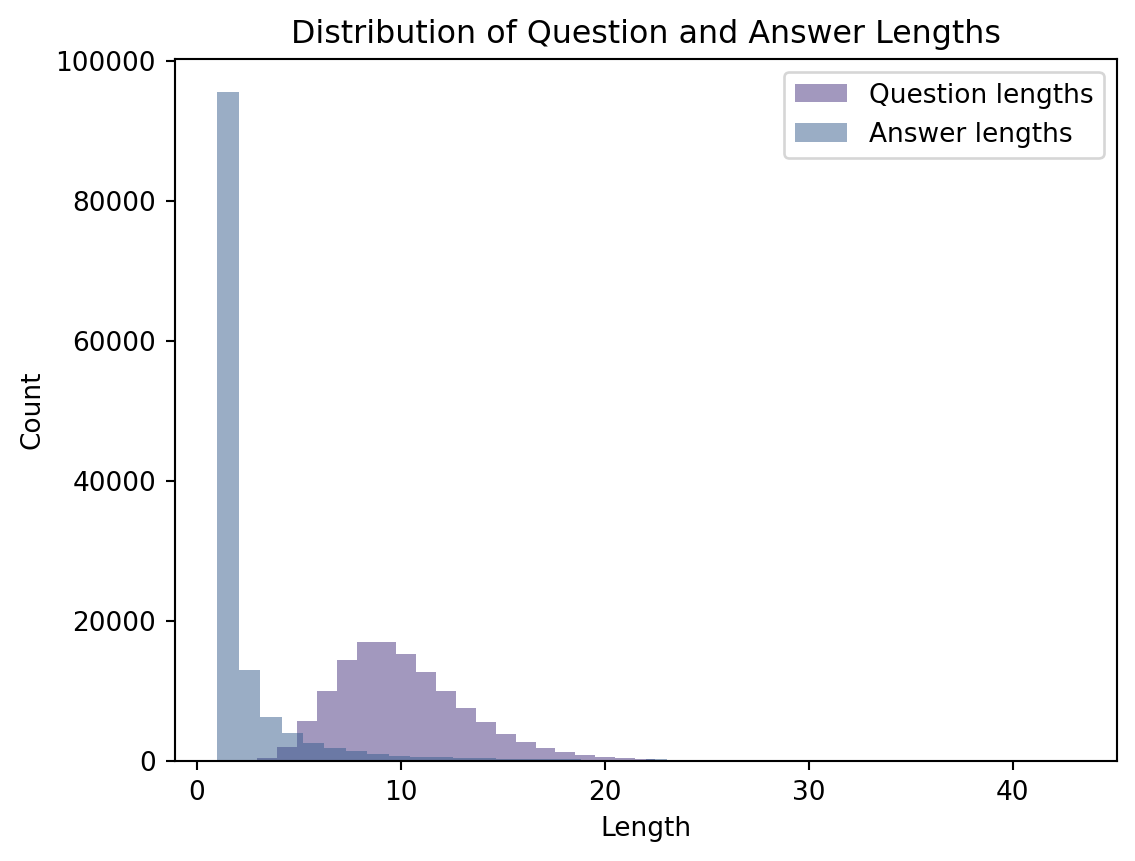

In [4]:
# Point 1: Distribution of question and answer lengths
#TODO: chiarezza su unità di misura
question_lengths = df['question_text'].astype(str).apply(lambda x: len(x.split()))
answer_lengths = df['answer_text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(dpi=190)
plt.hist(question_lengths, bins=40, alpha=0.5, label='Question lengths')
plt.hist(answer_lengths, bins=40, alpha=0.5, label='Answer lengths')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

Next, we plot the **distribution** of the answers, between **answerable** and **unanswerable**.

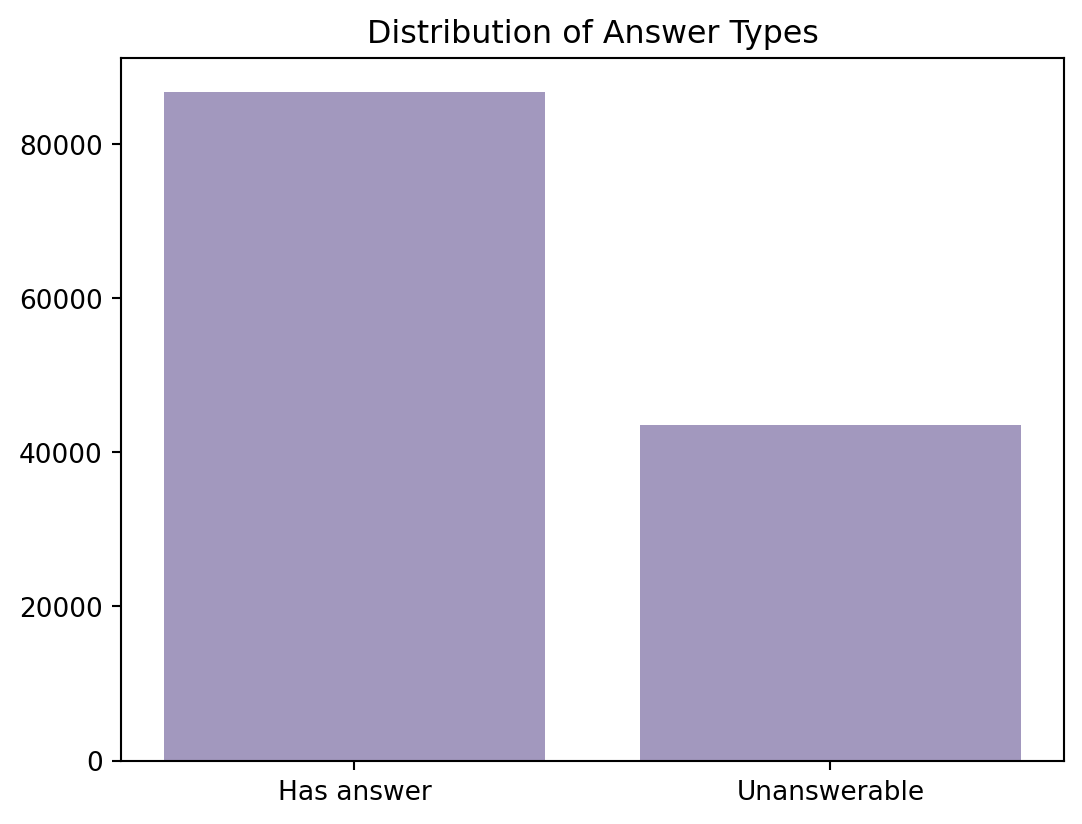

In [5]:
answer_types = df['is_impossible'].value_counts()
plt.figure(dpi=190)
plt.bar(['Has answer', 'Unanswerable'], answer_types, alpha=0.5)
plt.title('Distribution of Answer Types')
plt.show()

While **unanswerable** questions are clearly less, they're still more than enough to represent a relevant sample.

Now, we try applying **K-Nearest Neighbour clustering** to the contexts of the dataset, to see if there's any pattern.

In [6]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
def tsne_clusters(df):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df)
    # Fit a nearest neighbor model to the data
    nn_model = NearestNeighbors(n_neighbors=3, metric = 'cosine')
    nn_model.fit(X)
    
    # Get the nearest neighbors graph
    knn_graph = nn_model.kneighbors_graph(X).toarray()
    
    # Get the t-SNE embedded coordinates
    tsne_embedded = TSNE(n_components=2, perplexity=50, random_state=42, init = 'random', n_jobs = -1).fit_transform(X)
    
    # Get the cluster labels
    labels = np.argmax(knn_graph, axis=1)
    print(labels)
    
    # Set the colormap
    cmap = plt.get_cmap('rainbow')
    
    # Create a scatter plot of the t-SNE embedded coordinates, colored by cluster
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], c=labels, cmap=cmap)
    plt.title('t-SNE Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    
    # Add a legend to the scatter plot
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), markerfacecolor=cmap(i)) for i in range(len(np.unique(labels)))]
    plt.legend(handles=legend_elements, loc='best')
    
    
    plt.show()

In [8]:
def cluster_plot(df):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['context_text'])
    # Perform KNN for clustering
    k = 3  # Choose the number of clusters
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs = -1)
    knn.fit(X, [i // (len(df) // k) for i in range(len(df))])  # Assign labels based on indices

    # Perform t-SNE for visualization
    tsne = TSNE(n_components=2, perplexity=100, random_state=42, init = 'random', n_jobs = -1)
    X_tsne = tsne.fit_transform(X.toarray())

    # Plot the clusters
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=knn.predict(X))
    plt.legend()
    plt.show()

In [9]:
# Get a sample of 1000 context texts
sample_size = 1000
df_sample = df.sample(sample_size, random_state=42)

In [10]:
len(df_sample['context_text'])

1000

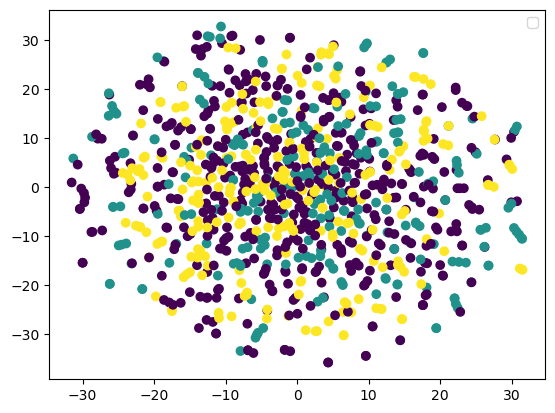

In [11]:
cluster_plot(df_sample)

With a sample of 1000, there seems to be **no** discernable **pattern**. This is actually relevant, because it means that there's little correlation between Question contexts, thus the models will have to be **consistent** across contexts.

## **Evaluation of the Models**
It's time to **test** our models. We'll be evaluating them with the [**evaluation script**](https://raw.githubusercontent.com/huggingface/transformers/5856999a9f2926923f037ecd8d27b8058bcf9dae/src/transformers/data/metrics/squad_metrics.py
) provided by the SQuAD team, in order to be consistent. 
As we said before, we'll test three well-known and capable Deep Learning Transformer-based models: **BERT**, **RoBERTa**, **DistilBERT**, both base and **fine-tuned**.


In [12]:
!pip install torch
!pip install torchvision
!pip install transformers

import os
import torch
import json
from subprocess import PIPE, STDOUT, Popen    # Execute the training from a standard Jupyter Notebook 

from transformers.data.metrics.squad_metrics import squad_evaluate
from transformers.data.processors.squad import SquadV2Processor

# this processor loads the SQuAD2.0 dev set examples
processor = SquadV2Processor()
examples = processor.get_dev_examples("/kaggle/input/squad-2", filename="dev-v2.0.json")

100%|██████████| 35/35 [00:07<00:00,  4.50it/s]


In [13]:
# download the run_squad.py training script
!curl -L -O https://raw.githubusercontent.com/huggingface/transformers/main/examples/legacy/question-answering/run_squad.py

# download the squad_metrics.py training script
!curl -L -O https://raw.githubusercontent.com/huggingface/transformers/5856999a9f2926923f037ecd8d27b8058bcf9dae/src/transformers/data/metrics/squad_metrics.py

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34907  100 34907    0     0   178k      0 --:--:-- --:--:-- --:--:--  178k
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29002  100 29002    0     0   151k      0 --:--:-- --:--:-- --:--:--  150k


In [14]:
def eval_model(model_dir):
    # load the predictions we generated earlier
    filename = model_dir + 'predictions_.json'
    preds = json.load(open(filename, 'rb'))

    # load the null score differences we generated earlier
    filename = model_dir + 'null_odds_.json'
    null_odds = json.load(open(filename, 'rb'))
    
    # the default threshold is set to 1.0 -- we'll leave it there for now
    results_default_thresh = squad_evaluate(examples, 
                                            preds, 
                                            no_answer_probs=null_odds, 
                                            no_answer_probability_threshold=1.0)

 
    results_f1_thresh = squad_evaluate(examples, 
                                       preds, 
                                       no_answer_probs=null_odds, 
                                       no_answer_probability_threshold=results_default_thresh['best_f1_thresh'])

    return results_f1_thresh

### **Bert-base**

In [15]:
if not os.path.exists('/kaggle/working/predictions_bert_base'):
    os.makedirs('/kaggle/working/predictions_bert_base')   

In [16]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'bert',                            
    '--model_name_or_path',  'bert-base-uncased',                                      # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_bert_base',                           # directory for model checkpoints and predictions    
    '--version_2_with_negative',                       
    '--do_lower_case',                                                                 # ** set this flag if using an uncased model; don't use for Cased Models  
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [17]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

bert_base_scores = eval_model('/kaggle/working/predictions_bert_base/')
bert_base_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 0.9770066537522109),
             ('f1', 4.8638896753941925),
             ('total', 11873),
             ('HasAns_exact', 0.16869095816464239),
             ('HasAns_f1', 7.953603595808923),
             ('HasAns_total', 5928),
             ('NoAns_exact', 1.7830109335576114),
             ('NoAns_f1', 1.7830109335576114),
             ('NoAns_total', 5945),
             ('best_exact', 50.07159100480081),
             ('best_exact_thresh', 0.0),
             ('best_f1', 50.07159100480081),
             ('best_f1_thresh', 0.0)])

### **Bert-base-finetuned**

In [18]:
if not os.path.exists('/kaggle/working/predictions_bert_base_finetuned'):
    os.makedirs('/kaggle/working/predictions_bert_base_finetuned')    

In [19]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'bert',                            
    '--model_name_or_path',  '/kaggle/input/bert-base-finetuned/bert_base_finetuned',  # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_bert_base_finetuned',                 # directory for model checkpoints and predictions    
    '--version_2_with_negative',                       
    '--do_lower_case',                                                                 # ** set this flag if using an uncased model; don't use for Cased Models  
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [20]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

bert_finetuned_scores = eval_model('/kaggle/working/predictions_bert_base_finetuned/')
bert_finetuned_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 73.62924281984334),
             ('f1', 76.6604671355054),
             ('total', 11873),
             ('HasAns_exact', 67.99932523616734),
             ('HasAns_f1', 74.07046664977312),
             ('HasAns_total', 5928),
             ('NoAns_exact', 79.2430613961312),
             ('NoAns_f1', 79.2430613961312),
             ('NoAns_total', 5945),
             ('best_exact', 73.76400235829192),
             ('best_exact_thresh', -5.087041616439819),
             ('best_f1', 76.6604671355051),
             ('best_f1_thresh', -4.027085185050964)])

### **RoBERTa-base**

In [21]:
if not os.path.exists('/kaggle/working/predictions_roberta_base'):
    os.makedirs('/kaggle/working/predictions_roberta_base')    

In [22]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'roberta',                            
    '--model_name_or_path',  'roberta-base',  # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_roberta_base',                 # directory for model checkpoints and predictions    
    '--version_2_with_negative',     
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [23]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

roberta_base_scores = eval_model('/kaggle/working/predictions_roberta_base/')
roberta_base_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 0.42112355765181503),
             ('f1', 3.1123766993879545),
             ('total', 11873),
             ('HasAns_exact', 0.016869095816464237),
             ('HasAns_f1', 5.407093210498178),
             ('HasAns_total', 5928),
             ('NoAns_exact', 0.8242220353238016),
             ('NoAns_f1', 0.8242220353238016),
             ('NoAns_total', 5945),
             ('best_exact', 50.07159100480081),
             ('best_exact_thresh', 0.0),
             ('best_f1', 50.07159100480081),
             ('best_f1_thresh', 0.0)])

### **RoBERTa-base-finetuned**

In [24]:
if not os.path.exists('/kaggle/working/predictions_roberta_base_finetuned'):
    os.makedirs('/kaggle/working/predictions_roberta_base_finetuned')    

In [25]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'roberta',                            
    '--model_name_or_path',  '/kaggle/input/roberta-base-finetuned/roberta_base_finetuned',  # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_roberta_base_finetuned',                 # directory for model checkpoints and predictions    
    '--version_2_with_negative',                       
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [26]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

roberta_finetuned_scores = eval_model('/kaggle/working/predictions_roberta_base_finetuned/')
roberta_finetuned_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 80.44302198264971),
             ('f1', 83.6370760149899),
             ('total', 11873),
             ('HasAns_exact', 74.83130904183535),
             ('HasAns_f1', 81.22857684311347),
             ('HasAns_total', 5928),
             ('NoAns_exact', 86.03868797308662),
             ('NoAns_f1', 86.03868797308662),
             ('NoAns_total', 5945),
             ('best_exact', 80.47671186726186),
             ('best_exact_thresh', -5.239290952682495),
             ('best_f1', 83.6370760149896),
             ('best_f1_thresh', -2.79168701171875)])

### **Distilbert-base**

In [27]:
if not os.path.exists('/kaggle/working/predictions_distilbert_base'):
    os.makedirs('/kaggle/working/predictions_distilbert_base')    

In [28]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'distilbert',                            
    '--model_name_or_path',  'distilbert-base-uncased',  # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_distilbert_base',                 # directory for model checkpoints and predictions    
    '--do_lower_case',                                                                 # ** set this flag if using an uncased model; don't use for Cased Models  
    '--version_2_with_negative',                       
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [29]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

distilbert_base_scores = eval_model('/kaggle/working/predictions_distilbert_base/')
distilbert_base_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 3.30160869199023),
             ('f1', 6.666229070005264),
             ('total', 11873),
             ('HasAns_exact', 0.20242914979757085),
             ('HasAns_f1', 6.941318783429969),
             ('HasAns_total', 5928),
             ('NoAns_exact', 6.3919259882254),
             ('NoAns_f1', 6.3919259882254),
             ('NoAns_total', 5945),
             ('best_exact', 50.07159100480081),
             ('best_exact_thresh', 0.0),
             ('best_f1', 50.07159100480081),
             ('best_f1_thresh', 0.0)])

### **Distilbert-base-finetuned**

In [30]:
if not os.path.exists('/kaggle/working/predictions_distilbert_base_finetuned'):
    os.makedirs('/kaggle/working/predictions_distilbert_base_finetuned')    

In [31]:
cmd = [
    'python', 
    'run_squad.py', 
    '--model_type', 'distilbert',                            
    '--model_name_or_path',  '/kaggle/input/distilbert-base-finetuned/distilbert_finetuned',  # specific model name of the given model type                                                       
    '--output_dir', '/kaggle/working/predictions_distilbert_base_finetuned',                 # directory for model checkpoints and predictions    
    '--do_lower_case',                                                                 # ** set this flag if using an uncased model; don't use for Cased Models  
    '--version_2_with_negative',                       
    '--do_eval',                                                                       # execute the evaluation method on the dev set -- note:                                                
    '--predict_file', '/kaggle/input/squad-2/dev-v2.0.json',                           # provide evaluation data (dev set)
    '--per_gpu_eval_batch_size', '16',                                                 # evaluation batch size for each gpu
    '--threads', '8',                                                                  # num of CPU threads to use for converting SQuAD examples to model features
    '--max_seq_length', '384',                                                         # maximum length allowed for the full input sequence 
    '--doc_stride', '128'                                                              # used for long documents that must be chunked into multiple features --                                                
]

In [32]:
p = Popen(cmd, stdout=PIPE, stderr=STDOUT)

for line in iter(p.stdout.readline, b''):
    print(">>> " + line.decode().rstrip())

distilbert_base_finetuned_scores = eval_model('/kaggle/working/predictions_distilbert_base_finetuned/')
distilbert_base_finetuned_scores

>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
>>>   warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
>>> /opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
>>> caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined 

OrderedDict([('exact', 67.05971532047502),
             ('f1', 70.0270294437076),
             ('total', 11873),
             ('HasAns_exact', 60.526315789473685),
             ('HasAns_f1', 66.46945354000304),
             ('HasAns_total', 5928),
             ('NoAns_exact', 73.57443229604709),
             ('NoAns_f1', 73.57443229604709),
             ('NoAns_total', 5945),
             ('best_exact', 67.21131980122968),
             ('best_exact_thresh', -4.118150591850281),
             ('best_f1', 70.02702944370753),
             ('best_f1_thresh', -3.356840133666992)])

## **Plots of the models**
Now that we have all the scores, we can **compare** them. 

In [33]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
def create_dataframe(dict_list, names):
    df = pd.DataFrame()
    for i, d in enumerate(dict_list):
        temp_dict = {}
        for key, value in d.items():
            if key != 'best_exact_thresh' and key != 'best_f1_thresh' and key != 'best_exact' and key != 'best_f1':
                temp_dict[key] = value
        temp_dict['name'] = names[i]
        # Move 'name' column to the beginning of the DataFrame
        cols = list(temp_dict.keys())
        cols.insert(0, cols.pop(cols.index('name')))
        temp_dict = {k: [v] for k, v in temp_dict.items()}
        df_temp = pd.DataFrame(temp_dict, columns=cols)
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
    return df

In [35]:
results = [bert_base_scores, bert_finetuned_scores,
           roberta_base_scores, roberta_finetuned_scores, 
           distilbert_base_scores, distilbert_base_finetuned_scores]
names = ['bert base', 'bert finetuned',
         'RoBERTa base', 'RoBERTa finetuned',
         'distilbert', 'distilbert finetuned']
df = create_dataframe(results, names)

In [36]:
df.head(len(names))

,name,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,NoAns_exact,NoAns_f1,NoAns_total
0,bert base,0.977007,4.863890,11873,0.168691,7.953604,5928,1.783011,1.783011,5945
1,bert finetuned,73.629243,76.660467,11873,67.999325,74.070467,5928,79.243061,79.243061,5945
2,RoBERTa base,0.421124,3.112377,11873,0.016869,5.407093,5928,0.824222,0.824222,5945
3,RoBERTa finetuned,80.443022,83.637076,11873,74.831309,81.228577,5928,86.038688,86.038688,5945
4,distilbert,3.301609,6.666229,11873,0.202429,6.941319,5928,6.391926,6.391926,5945
5,distilbert finetuned,67.059715,70.027029,11873,60.526316,66.469454,5928,73.574432,73.574432,5945


We can immediately see the huge **difference** that **fine-tuning** provides to the **F1 score**, which we hold as reference here. 
If we only consider base models, **DistilBERT** seems to be the best performing, although it matters very little given the **low scores** overall of the models.
Adding the **fine-tuned** models to the picture, **RoBERTa** takes the lead with a F1 score well over **83**, which is satisfactory overall.
For reference, we also printed the scores of only questions **with answers**, and the scores of only questions **without answers**. The overall leaderboard **does not change**.

We can now **plot** the scores for a quicker look.

In [37]:
def plots(columns_to_plot, names_to_plot, title):
    #set resolution
    plt.figure(dpi=500)
    
    # Get the unique names in the DataFrame
    unique_names = df['name'].unique()
    
    # Set up a colormap for the lines
    cmap = plt.cm.get_cmap('viridis')

    # Create a color dictionary to map each name to a color
    color_dict = {}
    for i, name in enumerate(unique_names):
        color_dict[name] = cmap(i / len(unique_names))
    
    # Iterate over the names to plot
    for name in names_to_plot:
        filtered_df = df[df['name'] == name]

        # Iterate over the columns to plot
        for col in columns_to_plot:
            # Get the values to plot
            values = filtered_df[col]

            # Get the color for this name
            color = color_dict[name]

            # Iterate over the values and plot each one as a horizontal line
            for value in values:
                plt.bar(name ,value, color=color, alpha=0.5, linewidth = 2)
                plt.text(name, value, f'{value:.2f}%', color = color, fontsize = 'large', ha = 'center', va = 'bottom')
       
    # Add a legend to the plot
    # Add x-axis labels
   
    plt.xticks(rotation='vertical')
    #plt.legend(names_to_plot)
    plt.title(title)

    
    # Show the plot
    plt.show()

/tmp/ipykernel_23/1135490756.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


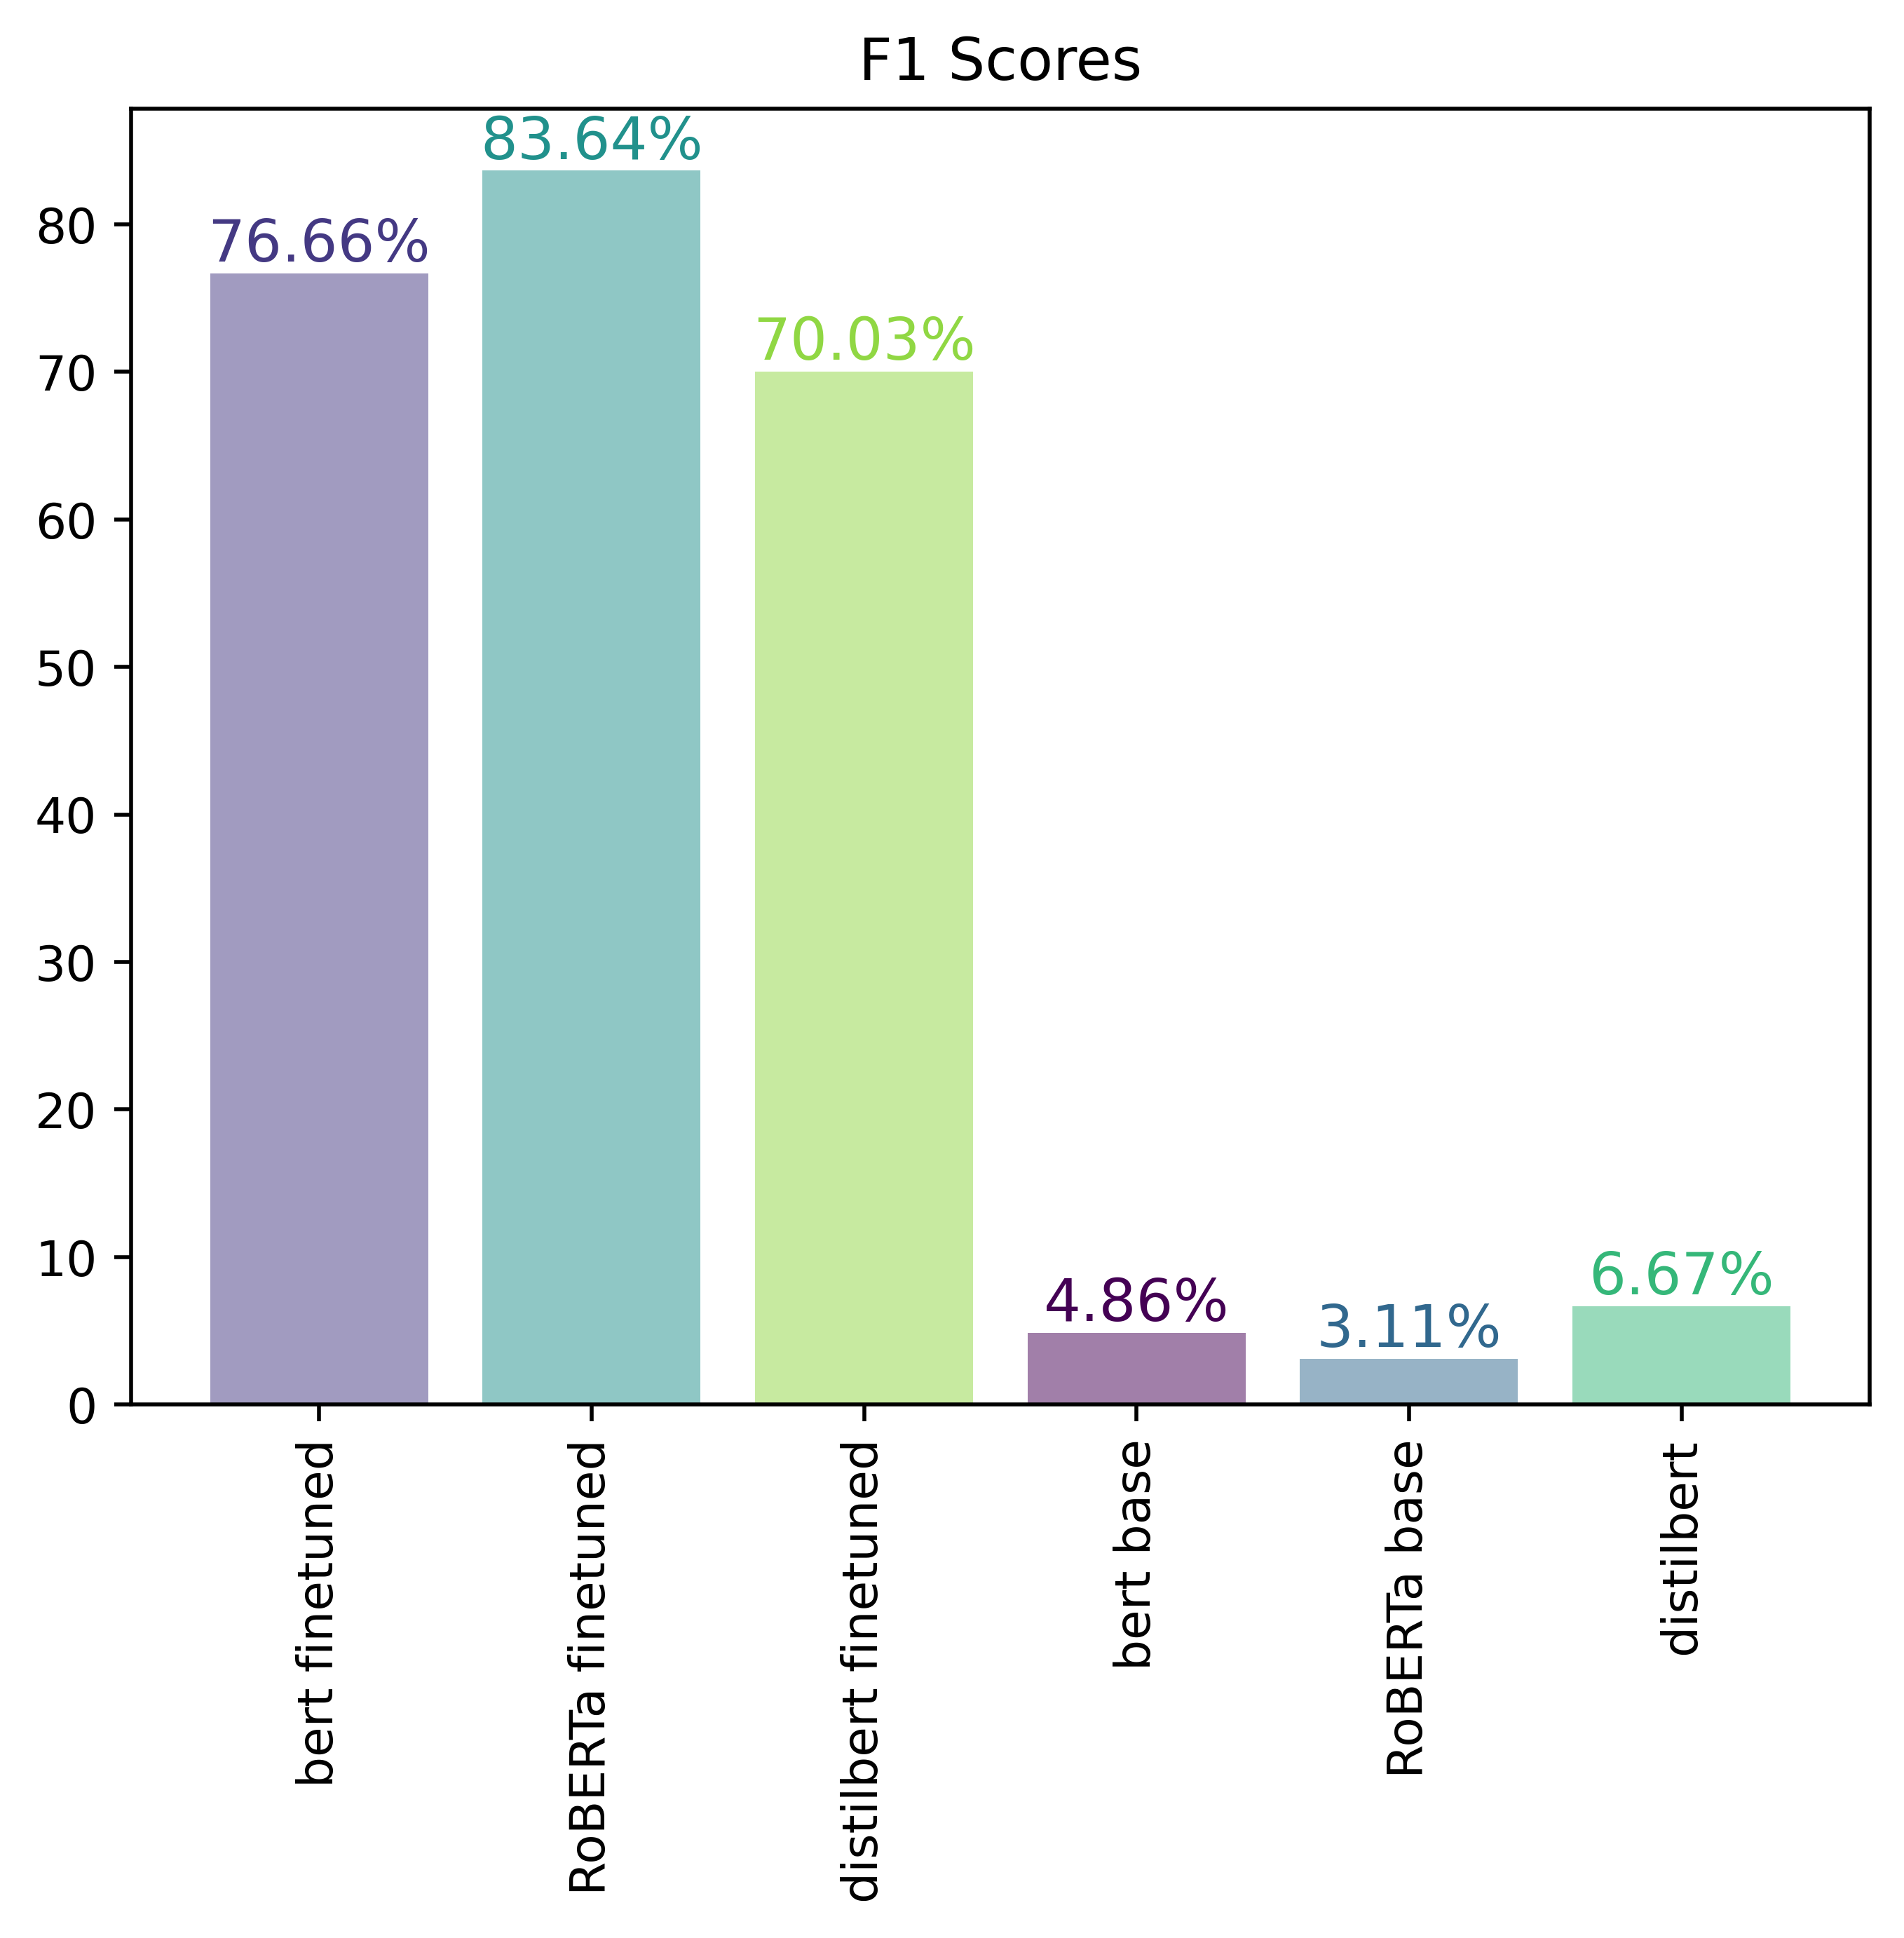

In [38]:
columns_to_plot = ['f1'] 
names_to_plot = ['bert finetuned', 'RoBERTa finetuned', 'distilbert finetuned',
                 'bert base', 'RoBERTa base', 'distilbert'] 
plots(columns_to_plot, names_to_plot, 'F1 Scores')

/tmp/ipykernel_23/1135490756.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


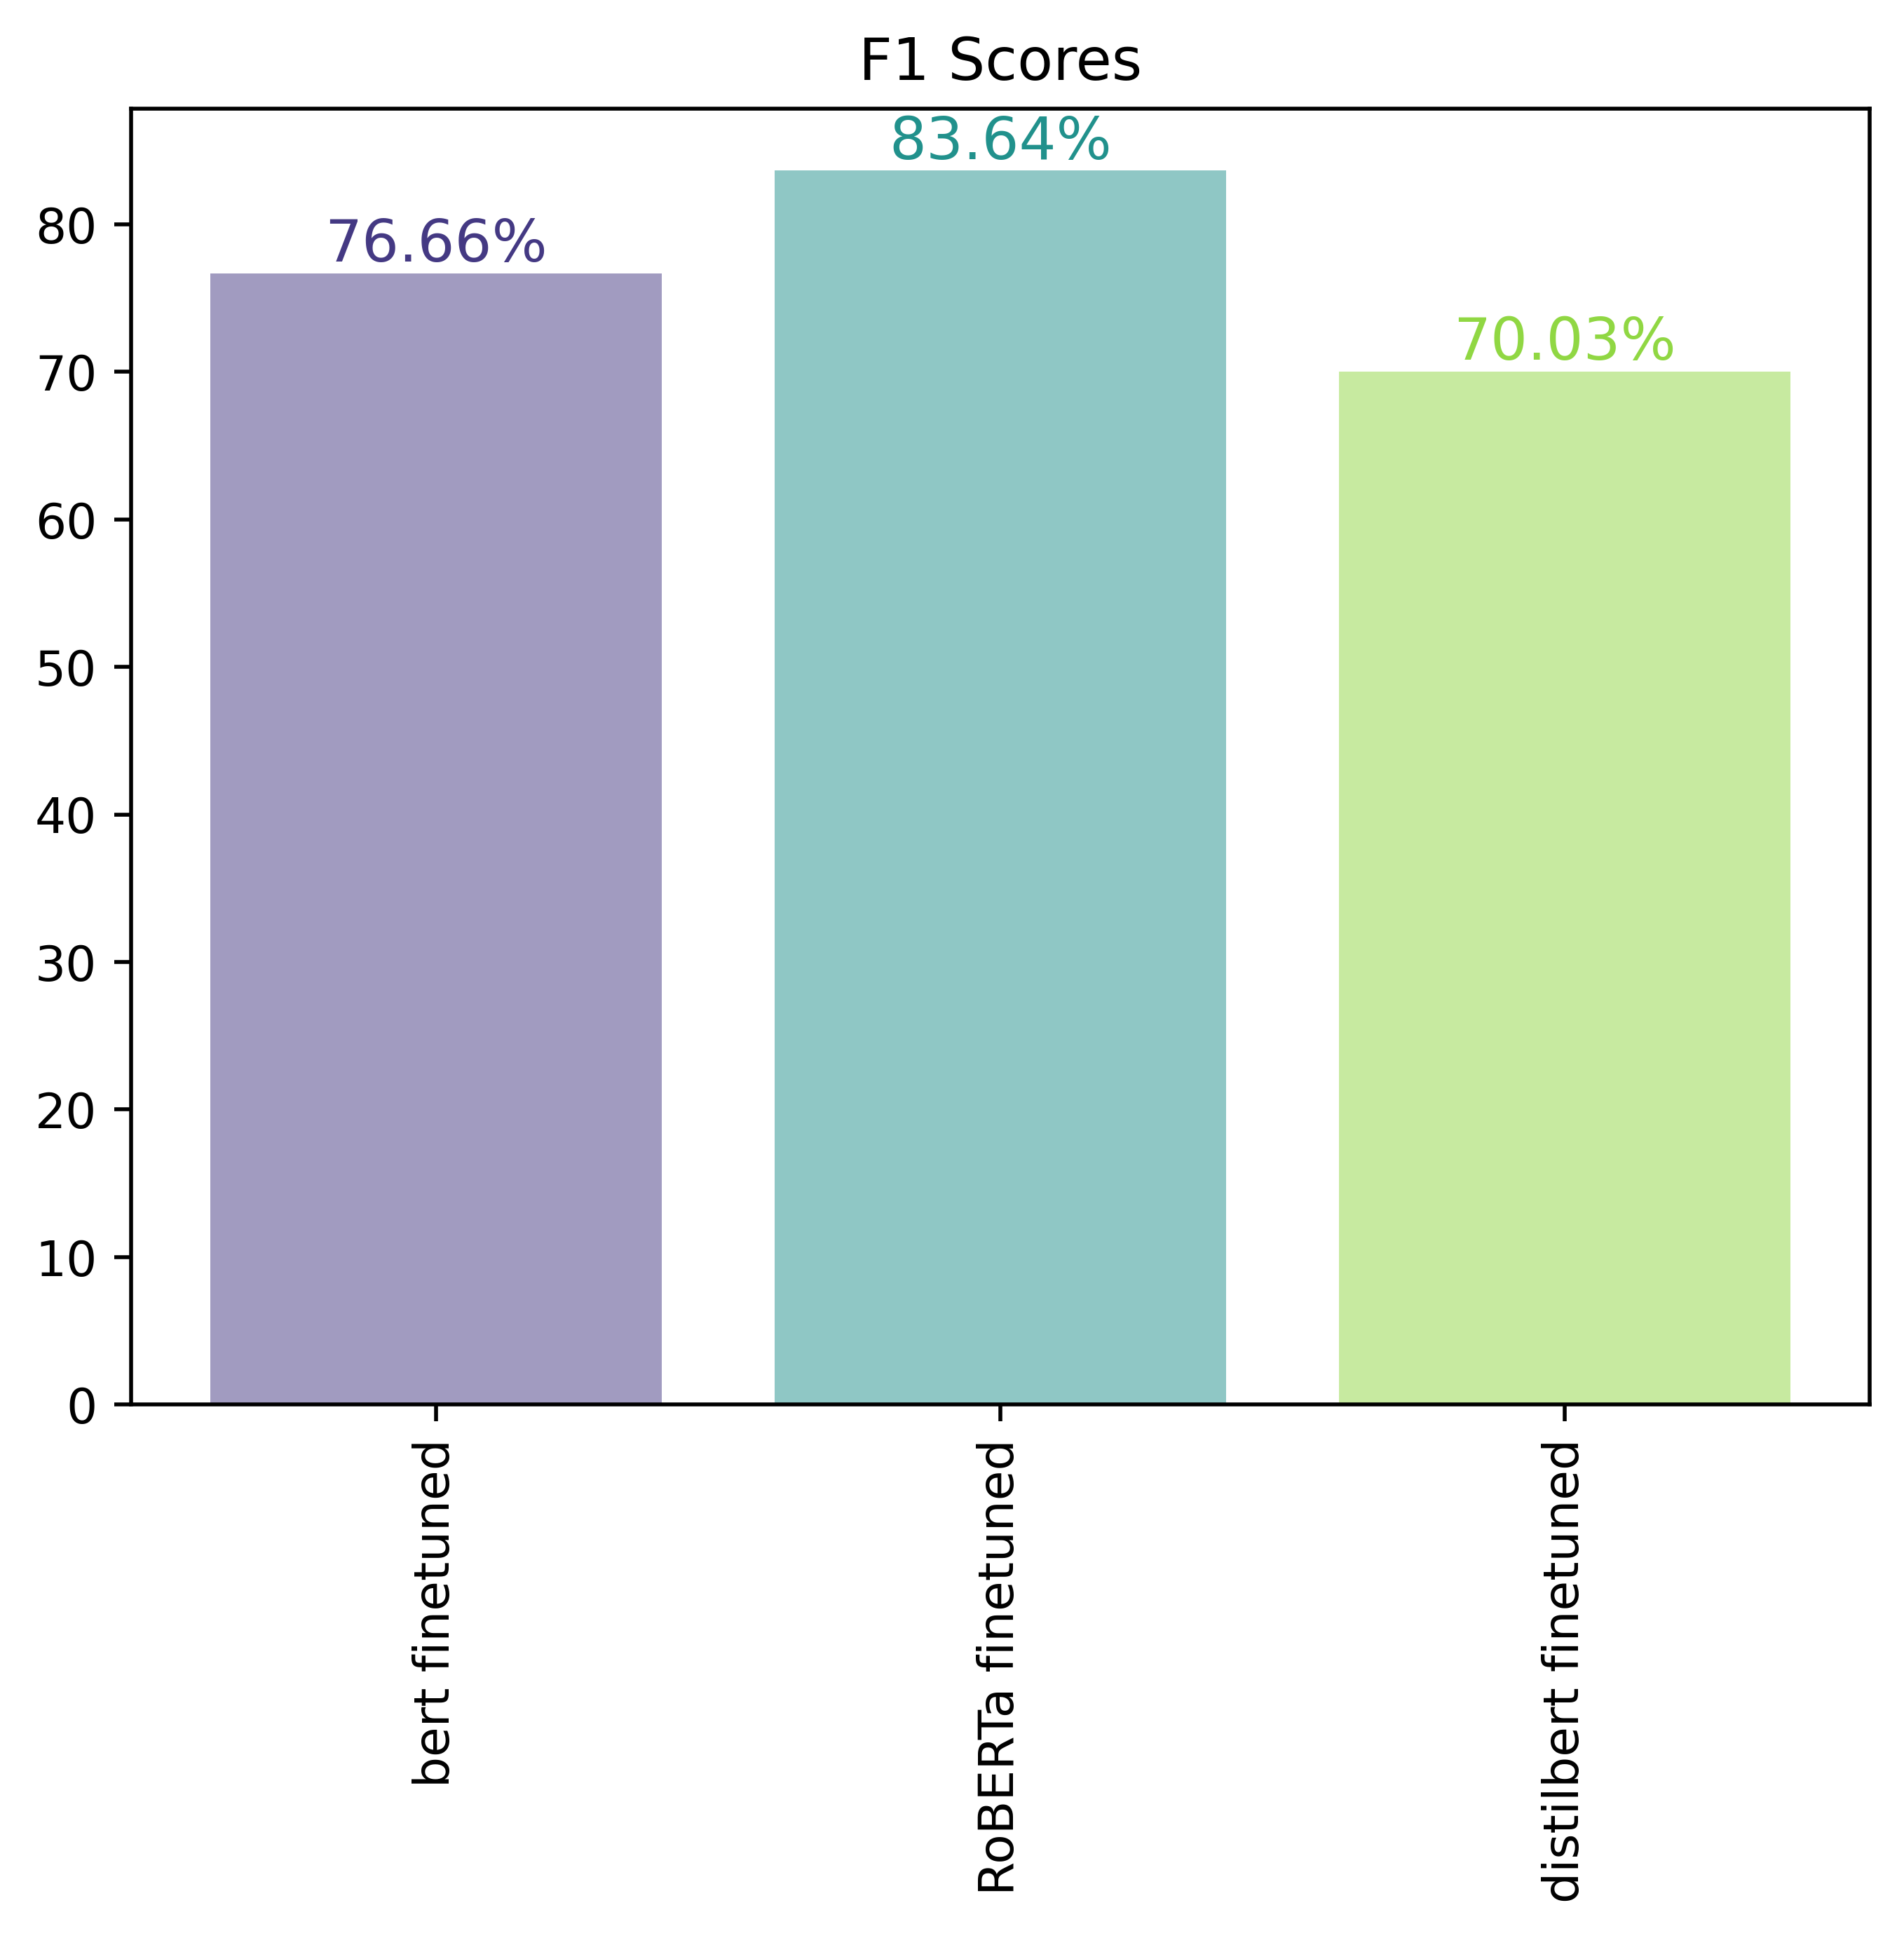

In [39]:
columns_to_plot = ['f1'] 
names_to_plot = ['bert finetuned', 'RoBERTa finetuned', 'distilbert finetuned'] 
plots(columns_to_plot, names_to_plot, 'F1 Scores')

## **Testing it with an example**
Now that we have evaluated our models, we can actually **test** their usage with a couple of examples. We'll use our best one, the **fine-tuned RoBERTa**.

In [40]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import numpy as np
import torch

In [41]:
# Load the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/roberta-base-finetuned/roberta_base_finetuned')
model = AutoModelForQuestionAnswering.from_pretrained('/kaggle/input/roberta-base-finetuned/roberta_base_finetuned')

In [42]:
def test_model(question, context, show = False):
    # 1. TOKENIZE THE INPUT
    # note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for 
    # exploration but you cannot feed that into a model. 
    tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/roberta-base-finetuned/roberta_base_finetuned')
    model = AutoModelForQuestionAnswering.from_pretrained('/kaggle/input/roberta-base-finetuned/roberta_base_finetuned')
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt") 

    # 2. OBTAIN MODEL SCORES
    # the AutoModelForQuestionAnswering class includes a span predictor on top of the model. 
    # the model returns answer start and end scores for each word in the text
    output = model(**inputs)
    answer_start_scores =  output.start_logits
    answer_end_scores = output.end_logits
    answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    
    start_accuracy = 1/(1+np.exp(-np.max(answer_start_scores.detach().numpy())))
    end_accuracy = 1/(1+np.exp(-np.max(answer_end_scores.detach().numpy())))

    # 3. GET THE ANSWER SPAN
    # once we have the most likely start and end tokens, we grab all the tokens between them
    # and convert tokens back to words!
    if (show):
        
        print('Question: ', end = ' ')
        print(question)
    
        print()
    
        print('Context: ', end = ' ')
        print(context)
    
        print()
    
        print('Answer:', end = ' ')
        if (answer == '<s>'):
            print('Answer not found')
            return answer 
    
        else :
            print(answer)
    
        print()
        
        print('Starting Accuracy: ', end = ' ')
        print(start_accuracy)
    
        print()
    
        print('Ending Accuracy: ', end = ' ')
        print(end_accuracy)
   
    
    return answer, start_accuracy, end_accuracy


We define a simple **question** and **answer** set:

In [43]:
question = "What is democracy?"

context = """Democracy is a form of government in which the people have the authority to deliberate and decide legislation ("direct democracy"),
or to choose governing officials to do so ("representative democracy"). Who is considered part of "the people" and how authority 
is shared among or delegated by the people has changed over time and at different rates in different countries. Features of democracy 
often include freedom of assembly, association, property rights, freedom of religion and speech, citizenship, consent of the governed, 
voting rights, freedom from unwarranted governmental deprivation of the right to life and liberty, and minority rights."""


And now we expect the model to understand where the answer of the question is in the context, and **retrieve** it.

In [44]:
ans, start_acc, end_acc = test_model(question, context, show = True)

Question:  What is democracy?

Context:  Democracy is a form of government in which the people have the authority to deliberate and decide legislation ("direct democracy"),
or to choose governing officials to do so ("representative democracy"). Who is considered part of "the people" and how authority 
is shared among or delegated by the people has changed over time and at different rates in different countries. Features of democracy 
often include freedom of assembly, association, property rights, freedom of religion and speech, citizenship, consent of the governed, 
voting rights, freedom from unwarranted governmental deprivation of the right to life and liberty, and minority rights.

Answer:  a form of government in which the people have the authority to deliberate and decide legislation

Starting Accuracy:  0.9997182390234256

Ending Accuracy:  0.9989476009215882


## Model Visualization
Now, a brief **information dump** on our RoBERTa model, deep-diving into its structure.

In [45]:
def n_params(model):
    total_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
    return total_params

In [46]:
def model_params(model):
    # Set up formatting
    name_width = max(len(name) for name, _ in model.named_parameters())
    count_width = max(len(str(param.numel())) for _, param in model.named_parameters())
    format_string = '{:<{name_width}} \t {:>{count_width}}'

    # Print the configuration for each layer
    total_params = 0
    print(format_string.format('Layer name', 'Number of parameters', name_width=name_width, count_width=count_width))
    for name, param in model.named_parameters():
        print(format_string.format(name, param.numel(), name_width=name_width, count_width=count_width))
        total_params += param.numel()

    # Print the total number of parameters in the model
    print(f'\nTotal number of parameters in the model: {total_params}')


Here we have the model **parameters**:

In [47]:
model_params(model)

Layer name                                                 	 Number of parameters
roberta.embeddings.word_embeddings.weight                  	 38603520
roberta.embeddings.position_embeddings.weight              	   394752
roberta.embeddings.token_type_embeddings.weight            	      768
roberta.embeddings.LayerNorm.weight                        	      768
roberta.embeddings.LayerNorm.bias                          	      768
roberta.encoder.layer.0.attention.self.query.weight        	   589824
roberta.encoder.layer.0.attention.self.query.bias          	      768
roberta.encoder.layer.0.attention.self.key.weight          	   589824
roberta.encoder.layer.0.attention.self.key.bias            	      768
roberta.encoder.layer.0.attention.self.value.weight        	   589824
roberta.encoder.layer.0.attention.self.value.bias          	      768
roberta.encoder.layer.0.attention.output.dense.weight      	   589824
roberta.encoder.layer.0.attention.output.dense.bias        	      768
roberta.

In [48]:
!pip install torchview

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


And a **visual** **representation** of our model at work:

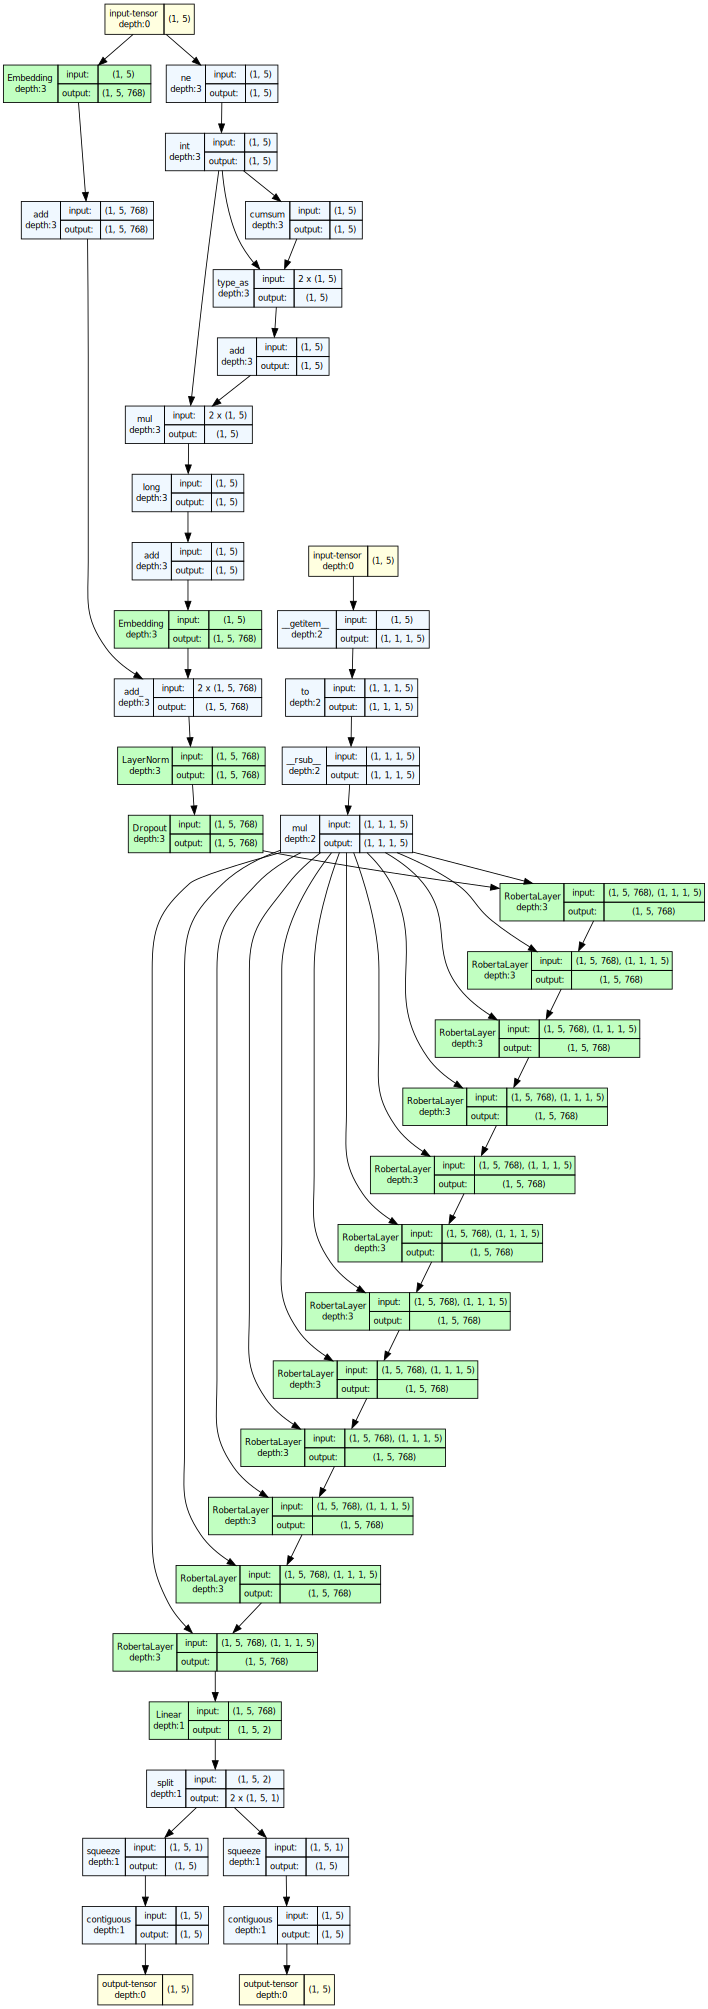

In [49]:
from transformers import AutoModel, AutoTokenizer
from torchview import draw_graph


inputs = tokenizer("Hello world!", return_tensors="pt")

model_graph = draw_graph(model, input_data=inputs)

model_graph.visual_graph

## **Q&A from Wikipedia** 

Technical details and graphs are good and all, but let's see the model **in action**.
We've implemented the **Wikipedia API** in order to feed our model just the question: the API will find the corresponding **Wikipedia page** in order to provide the **context**. Then, it's up to our model to find and provide the **answer**.

In [50]:
!pip install wikipedia-api
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
!pip install nltk
import nltk
nltk.download('punkt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [52]:
!pip install wikipedia

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... - \ done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=df6af6d2a768c800bd52a05c33d97b90271a49f2c66f300da2b988cf01354b87
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [53]:
import wikipedia

In [54]:
def WikiTitle(input_text):
    try:
        page = wikipedia.page(input_text)
        title_page = page.title
        return title_page
    except wikipedia.exceptions.DisambiguationError as e:
        # Handle disambiguation pages
        options = e.options
        # You can provide a user prompt to select the correct option from 'options' list
        return None
    except wikipedia.exceptions.PageError:
        # Handle cases where the page does not exist
        return None


In [55]:
def WikiToken(title):
    page = wiki_wiki.page(title)
    article_text = page.text
    tokens = nltk.tokenize.word_tokenize(article_text)
    return tokens

In [56]:
def WikiAnswer(question, title, show = False):
    
    tokens = WikiToken(title)
    limit = 300
    divided = [tokens[i:i+limit] for i in range(0, len(tokens), limit)]
    
    start_acc = []
    end_acc = []
    answers = []
    
    for group in divided:
        sentence = ' '.join(group)
        ans,st,end = test_model(question,sentence)
        if (ans != '<s>'):
            answers.append(ans)
            start_acc.append(st)
            end_acc.append(end)
            
    if len(answers)==0:
        print('No answer found :(')
        return 
            
    best_start_ans = answers[np.argmax(start_acc)]
    best_end_ans = answers[np.argmax(end_acc)]
    
    
    print(best_start_ans if np.max(start_acc) > np.max(end_acc) else best_end_ans)
    
    if show:
        print(best_start_ans)
        print(np.max(start_acc))

        print()

        print(best_end_ans)
        print(np.max(end_acc))
    
    return

Look at it go:

In [57]:
question = "Which is the song of FIFA World Cup 2010 ?"
WikiAnswer(question, WikiTitle(question))

 Waka Waka


In [58]:
question = "When was Ryan Reynolds born ?"
WikiAnswer(question, WikiTitle(question))

 October 23 , 1976


In [59]:
question = "What is the speed of light ?"
WikiAnswer(question, WikiTitle(question))

 186282 miles per second


In [60]:
question = "What is the speed of light in km/s ?"
WikiAnswer(question, WikiTitle(question))

 299792.5±3.0


In [61]:
question = "What is the name of the australian Prime Minister ?"
WikiAnswer(question, WikiTitle(question))

 Anthony Albanese
